# Using Supplychainpy with Pandas
** *by Kevin Fasusi* **

In workbook 0.0.4-Supplychainpy-Inventory-Analysis, we used standard Python types (dict, list, tuple, etc..). This analysis can also be conducted using a Pandas `DataFrame` giving us many more options for quick and easy analysis. 

To use Supplychainpy library with Pandas, we first need to import the right modules and read a CSV file to a Pandas DataFrame. The `%matplotlib inline` statement is used so we can see the matplotlib plots in the jupyter notebook.
First, we read the raw data into the Pandas `DataFrame`, as shown below.

In [1]:
%matplotlib inline

import matplotlib
import pandas as pd

from supplychainpy.model_inventory import analyse
from supplychainpy.model_demand import simple_exponential_smoothing_forecast
from supplychainpy.sample_data.config import ABS_FILE_PATH
from decimal import Decimal
raw_df =pd.read_csv(ABS_FILE_PATH['COMPLETE_CSV_SM'])

Passing a Pandas `DataFrame` as a keyword argument (df=) returns a `DataFrame` with the inventory profile analysed. Excluding the import statements, this can be achieved in 3 lines of code. There are several columns, so the print statement has been limited to a few ('sku','quantity_on_hand', 'excess_stock', 'shortages', 'ABC_XYZ_Classification').

In [2]:
orders_df = raw_df[['Sku','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]
#orders_df.set_index('Sku')
analyse_kv =dict(
    df=raw_df, 
    start=1, 
    interval_length=12, 
    interval_type='months',
    z_value=Decimal(1.28), 
    reorder_cost=Decimal(400), 
    retail_price=Decimal(455), 
    file_type='csv', 
    currency='USD'
)
analysis_df = analyse( **analyse_kv)
print(analysis_df[['sku','quantity_on_hand', 'excess_stock', 'shortages', 'ABC_XYZ_Classification']])

          sku quantity_on_hand excess_stock shortages ABC_XYZ_Classification
0   KR202-209             1003            0      5969                     BY
1   KR202-210             3224            0         0                     CY
2   KR202-211              390            0      7099                     CY
3   KR202-212              390            0      7759                     CY
4   KR202-213             2095            0         0                     CY
5   KR202-214               55            0      5824                     CY
6   KR202-215             4308          732         0                     CY
7   KR202-216               34            0      6999                     CY
8   KR202-217              390            0      7245                     BY
9   KR202-218             3535            0         0                     CZ
10  KR202-219              334            0      5917                     CZ
11  KR202-220             3434            0         0                     BY

Before we can make a forecast, we need to select an SKU from the `analysis_df` variable. After selection, we slice the row to retrieve only orders data and convert to a `Series`. 

In [3]:
row_ds = raw_df[raw_df['Sku']=='KR202-212'].squeeze()
print(row_ds[1:12])

jan     104
feb    2262
mar     350
apr     528
may    2570
jun    1216
jul    1101
aug    2755
sep    2856
oct    2381
nov    1867
Name: 3, dtype: object


Now that we have a `series` of orders data fro the SKU `KR202-212`, we can now perform a forecast using the `model_demand` module. We can perform a simple_exponential_smoothing_forecast by passing the forecasting function the orders data using the keyword parameter `ds=`.

In [4]:
ses_df = simple_exponential_smoothing_forecast(ds=row_ds[1:12], length=12, smoothing_level_constant=0.5)
print(ses_df)

{'alpha': 0.5, 'regression': [377.59999999999991, 602.09090909090901, 826.58181818181811, 1051.0727272727272, 1275.5636363636363, 1500.0545454545454, 1724.5454545454545, 1949.0363636363636, 2173.5272727272727, 2398.0181818181818, 2622.5090909090909, 2847.0], 'forecast': [2137.226296164773, 2137.226296164773, 2137.226296164773, 2137.226296164773, 2137.226296164773], 'mape': 100.69830747447692, 'statistics': {'intercept': 377.59999999999991, 'std_residuals': 4793.7283216530095, 'test_statistic': 3.8634855288615153, 'trend': True, 'pvalue': 0.0047852515832242743, 'slope_standard_error': 58.105797838218294, 'slope': 224.4909090909091}, 'forecast_breakdown': [{'alpha': 0.5, 'squared_error': 2345353.024793389, 'one_step_forecast': 1635.4545454545455, 't': 1, 'level_estimates': 869.72727272727275, 'demand': 104, 'forecast_error': -1531.4545454545455}, {'alpha': 0.5, 'squared_error': 1938423.3471074379, 'one_step_forecast': 869.72727272727275, 't': 2, 'level_estimates': 1565.8636363636365, 'de

In [5]:
print(ses_df.get('forecast', 'UNKNOWN'))

[2137.226296164773, 2137.226296164773, 2137.226296164773, 2137.226296164773, 2137.226296164773]


If we check the statistcs for the forecast we can see whether there is a linear trend and subsequently if the forecast is useful.

In [6]:
print(ses_df.get('statistics', 'UNKNOWN'),'\n mape: {}'.format(ses_df.get('mape', 'UNKNOWN')))

{'intercept': 377.59999999999991, 'std_residuals': 4793.7283216530095, 'test_statistic': 3.8634855288615153, 'trend': True, 'pvalue': 0.0047852515832242743, 'slope_standard_error': 58.105797838218294, 'slope': 224.4909090909091} 
 mape: 100.69830747447692


The breakdown of the forecast is returned with the `forecast` and `statistics`.

In [7]:
print(ses_df.get('forecast_breakdown', 'UNKNOWN'))

[{'alpha': 0.5, 'squared_error': 2345353.024793389, 'one_step_forecast': 1635.4545454545455, 't': 1, 'level_estimates': 869.72727272727275, 'demand': 104, 'forecast_error': -1531.4545454545455}, {'alpha': 0.5, 'squared_error': 1938423.3471074379, 'one_step_forecast': 869.72727272727275, 't': 2, 'level_estimates': 1565.8636363636365, 'demand': 2262, 'forecast_error': 1392.2727272727273}, {'alpha': 0.5, 'squared_error': 1478324.3822314052, 'one_step_forecast': 1565.8636363636365, 't': 3, 'level_estimates': 957.93181818181824, 'demand': 350, 'forecast_error': -1215.8636363636365}, {'alpha': 0.5, 'squared_error': 184841.36828512402, 'one_step_forecast': 957.93181818181824, 't': 4, 'level_estimates': 742.96590909090912, 'demand': 528, 'forecast_error': -429.93181818181824}, {'alpha': 0.5, 'squared_error': 3338053.5693440083, 'one_step_forecast': 742.96590909090912, 't': 5, 'level_estimates': 1656.4829545454545, 'demand': 2570, 'forecast_error': 1827.034090909091}, {'alpha': 0.5, 'squared_er

We can convert the `forecast_breakdown` back into a `DataFrame`.

In [8]:
forecast_breakdown_df = pd.DataFrame(ses_df.get('forecast_breakdown', 'UNKNOWN'))
print(forecast_breakdown_df)

    alpha  demand  forecast_error  level_estimates  one_step_forecast  \
0     0.5     104    -1531.454545       869.727273        1635.454545   
1     0.5    2262     1392.272727      1565.863636         869.727273   
2     0.5     350    -1215.863636       957.931818        1565.863636   
3     0.5     528     -429.931818       742.965909         957.931818   
4     0.5    2570     1827.034091      1656.482955         742.965909   
5     0.5    1216     -440.482955      1436.241477        1656.482955   
6     0.5    1101     -335.241477      1268.620739        1436.241477   
7     0.5    2755     1486.379261      2011.810369        1268.620739   
8     0.5    2856      844.189631      2433.905185        2011.810369   
9     0.5    2381      -52.905185      2407.452592        2433.905185   
10    0.5    1867     -540.452592      2137.226296        2407.452592   

    squared_error   t  
0    2.345353e+06   1  
1    1.938423e+06   2  
2    1.478324e+06   3  
3    1.848414e+05   4  
4  

Let's look at the `demand` and the `one_step_forecast` in a chart.

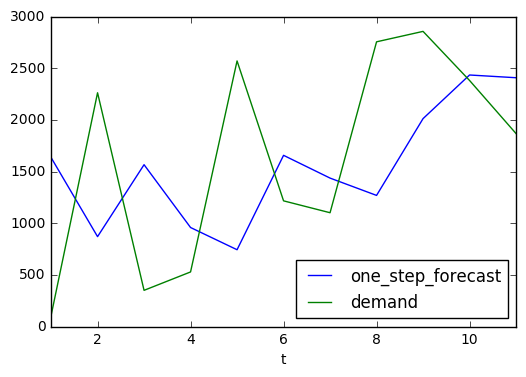

In [9]:
forecast_breakdown_df.plot(x='t', y=['one_step_forecast','demand'])

We can also create the data points for the regression line.

In [10]:
regression = {'regression': [(ses_df.get('statistics')['slope']* i ) + ses_df.get('statistics')['intercept'] for i in range(1,12)]}
print(regression)

{'regression': [602.09090909090901, 826.58181818181811, 1051.0727272727272, 1275.5636363636363, 1500.0545454545454, 1724.5454545454545, 1949.0363636363636, 2173.5272727272727, 2398.0181818181818, 2622.5090909090909, 2847.0]}


We can add the regression data points to the forecast breakdown DataFrame.

In [11]:
forecast_breakdown_df['regression'] = regression.get('regression')
print(forecast_breakdown_df)

    alpha  demand  forecast_error  level_estimates  one_step_forecast  \
0     0.5     104    -1531.454545       869.727273        1635.454545   
1     0.5    2262     1392.272727      1565.863636         869.727273   
2     0.5     350    -1215.863636       957.931818        1565.863636   
3     0.5     528     -429.931818       742.965909         957.931818   
4     0.5    2570     1827.034091      1656.482955         742.965909   
5     0.5    1216     -440.482955      1436.241477        1656.482955   
6     0.5    1101     -335.241477      1268.620739        1436.241477   
7     0.5    2755     1486.379261      2011.810369        1268.620739   
8     0.5    2856      844.189631      2433.905185        2011.810369   
9     0.5    2381      -52.905185      2407.452592        2433.905185   
10    0.5    1867     -540.452592      2137.226296        2407.452592   

    squared_error   t   regression  
0    2.345353e+06   1   602.090909  
1    1.938423e+06   2   826.581818  
2    1.47832

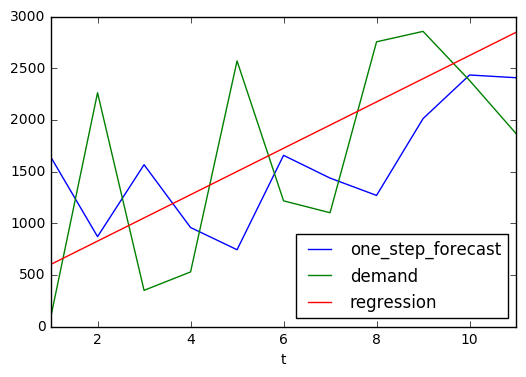

In [12]:
forecast_breakdown_df.plot(x='t', y=['one_step_forecast','demand', 'regression'])

We have a choice now; we can use another alpha and repeat the analysis to reduce the Standard Error or use supplychainpy's `optimise=True` parameter to use an evolutionary algorithm and get closer to an optimal solution.

In [13]:
opt_ses_df = simple_exponential_smoothing_forecast(ds=row_ds[1:12], length=12, smoothing_level_constant=0.4,optimise=True)
print(opt_ses_df)

{'optimal_alpha': 0.007621892788827744, 'regression': [377.59999999999991, 602.09090909090901, 826.58181818181811, 1051.0727272727272, 1275.5636363636363, 1500.0545454545454, 1724.5454545454545, 1949.0363636363636, 2173.5272727272727, 2398.0181818181818, 2622.5090909090909, 2847.0], 'forecast': [1636.5634006723544, 1636.5634006723544, 1636.5634006723544, 1636.5634006723544, 1636.5634006723544], 'mape': 209.17456826884523, 'statistics': {'intercept': 377.59999999999991, 'std_residuals': 4793.7283216530095, 'test_statistic': 3.8634855288615153, 'trend': True, 'pvalue': 0.0047852515832242743, 'slope_standard_error': 58.105797838218294, 'slope': 224.4909090909091}, 'forecast_breakdown': [{'alpha': 0.007621892788827744, 'squared_error': 2345353.024793389, 'one_step_forecast': 1635.4545454545455, 't': 1, 'level_estimates': 1623.781963098128, 'demand': 104, 'forecast_error': -1531.4545454545455}, {'alpha': 0.007621892788827744, 'squared_error': 407322.26262687921, 'one_step_forecast': 1623.78

In [14]:
print(opt_ses_df.get('statistics', 'UNKNOWN'),'\n mape: {}'.format(opt_ses_df.get('mape', 'UNKNOWN')))

{'intercept': 377.59999999999991, 'std_residuals': 4793.7283216530095, 'test_statistic': 3.8634855288615153, 'trend': True, 'pvalue': 0.0047852515832242743, 'slope_standard_error': 58.105797838218294, 'slope': 224.4909090909091} 
 mape: 209.17456826884523


In [15]:
print(opt_ses_df.get('forecast', 'UNKNOWN')) 

[1636.5634006723544, 1636.5634006723544, 1636.5634006723544, 1636.5634006723544, 1636.5634006723544]


In [16]:
optimised_regression = {'regression': [(opt_ses_df.get('statistics')['slope']* i ) + opt_ses_df.get('statistics')['intercept'] for i in range(1,12)]}
print(optimised_regression)

{'regression': [602.09090909090901, 826.58181818181811, 1051.0727272727272, 1275.5636363636363, 1500.0545454545454, 1724.5454545454545, 1949.0363636363636, 2173.5272727272727, 2398.0181818181818, 2622.5090909090909, 2847.0]}


In [17]:
opt_forecast_breakdown_df = pd.DataFrame(opt_ses_df.get('forecast_breakdown', 'UNKNOWN'))

In [18]:
opt_forecast_breakdown_df['regression'] = optimised_regression.get('regression')
print(opt_forecast_breakdown_df)

       alpha  demand  forecast_error  level_estimates  one_step_forecast  \
0   0.007622     104    -1531.454545      1623.781963        1635.454545   
1   0.007622    2262      638.218037      1628.646393        1623.781963   
2   0.007622     350    -1278.646393      1618.900687        1628.646393   
3   0.007622     528    -1090.900687      1610.585959        1618.900687   
4   0.007622    2570      959.414041      1617.898510        1610.585959   
5   0.007622    1216     -401.898510      1614.835282        1617.898510   
6   0.007622    1101     -513.835282      1610.918885        1614.835282   
7   0.007622    2755     1144.081115      1619.638949        1610.918885   
8   0.007622    2856     1236.361051      1629.062360        1619.638949   
9   0.007622    2381      751.937640      1634.793548        1629.062360   
10  0.007622    1867      232.206452      1636.563401        1634.793548   

    squared_error   t   regression  
0    2.345353e+06   1   602.090909  
1    4.073223

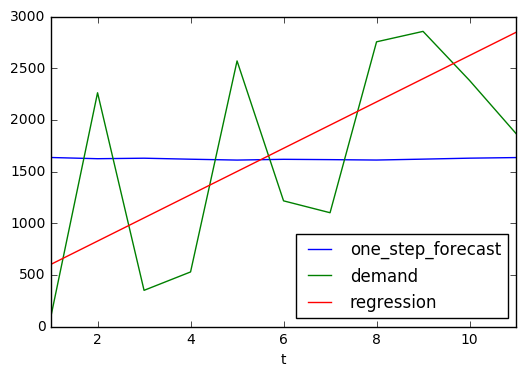

In [19]:
opt_forecast_breakdown_df.plot(x='t', y=['one_step_forecast','demand', 'regression'])